In [15]:
import pandas as pd

# if you renamed it:
df = pd.read_csv("../data/wine_reviews.csv")

# if you kept original name:
# df = pd.read_csv("../data/winemag-data-130k-v2.csv")

df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [16]:
df_clean = df[["description", "points", "price", "country", "province", "variety", "winery"]].copy()

# remove rows WITHOUT price or description
df_clean = df_clean.dropna(subset=["price", "description", "variety"])

df_clean.shape

(120974, 7)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", max_features=8000)
X = vectorizer.fit_transform(df_clean["description"])

In [18]:
from sklearn.decomposition import PCA

# Reduce to 50 components
pca = PCA(n_components=50, random_state=42)
X_reduced = pca.fit_transform(X.toarray())

X_reduced.shape

(120974, 50)

In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

df_clean["cluster"] = clusters

In [20]:
pip install umap-learn


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
import umap.umap_ as umap

reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_reduced)

X_umap.shape

/Users/defneguler/Desktop/data-science-portfolio/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(120974, 2)

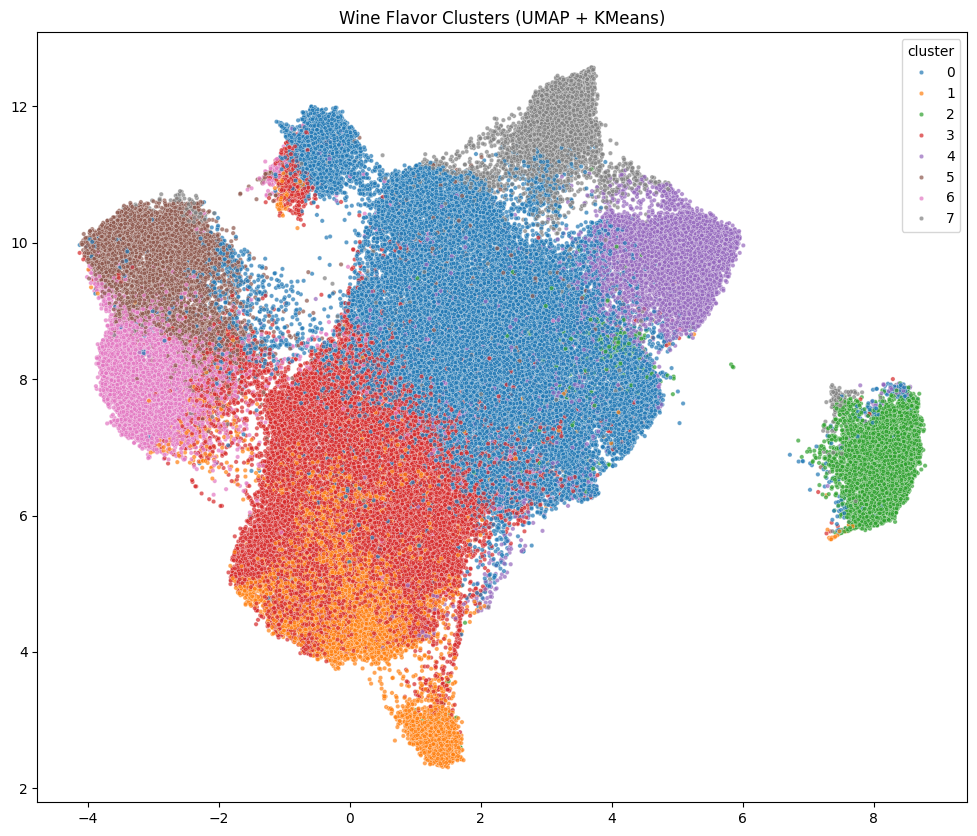

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.scatterplot(
    x=X_umap[:,0],
    y=X_umap[:,1],
    hue=df_clean["cluster"],
    palette="tab10",
    s=10,
    alpha=0.7
)
plt.title("Wine Flavor Clusters (UMAP + KMeans)")
plt.show()

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def get_top_words(cluster_number, n_words=20):
    texts = df_clean[df_clean["cluster"] == cluster_number]["description"]
    vec = TfidfVectorizer(stop_words="english", max_features=5000)
    Xc = vec.fit_transform(texts)
    sums = Xc.sum(axis=0)
    words = np.array(vec.get_feature_names_out())
    top_indices = np.argsort(sums)[0, -n_words:][0]
    return list(words[top_indices])

for i in range(8):
    print(f"\nCLUSTER {i} TOP WORDS:")
    print(get_top_words(i))


CLUSTER 0 TOP WORDS:
[array(['bodied', 'dark', 'acidity', 'notes', 'soft', 'drink',
       'blackberry', 'ripe', 'spice', 'oak', 'palate', 'red', 'aromas',
       'finish', 'tannins', 'black', 'cherry', 'fruit', 'flavors', 'wine'],
      dtype=object)]

CLUSTER 1 TOP WORDS:
[array(['yellow', 'notes', 'crisp', 'offers', 'nose', 'peach', 'lemon',
       'fresh', 'green', 'citrus', 'wine', 'finish', 'fruit', 'acidity',
       'pear', 'white', 'flavors', 'aromas', 'palate', 'apple'],
      dtype=object)]

CLUSTER 2 TOP WORDS:
[array(['raspberry', 'clove', 'plum', 'opens', 'firm', 'dried', 'licorice',
       'ripe', 'pepper', 'drink', 'spice', 'berry', 'offers', 'alongside',
       'red', 'palate', 'aromas', 'tannins', 'cherry', 'black'],
      dtype=object)]

CLUSTER 3 TOP WORDS:
[array(['orange', 'lime', 'crisp', 'nose', 'ripe', 'fresh', 'notes',
       'lemon', 'sweet', 'white', 'dry', 'peach', 'citrus', 'aromas',
       'palate', 'acidity', 'finish', 'fruit', 'wine', 'flavors'],
      

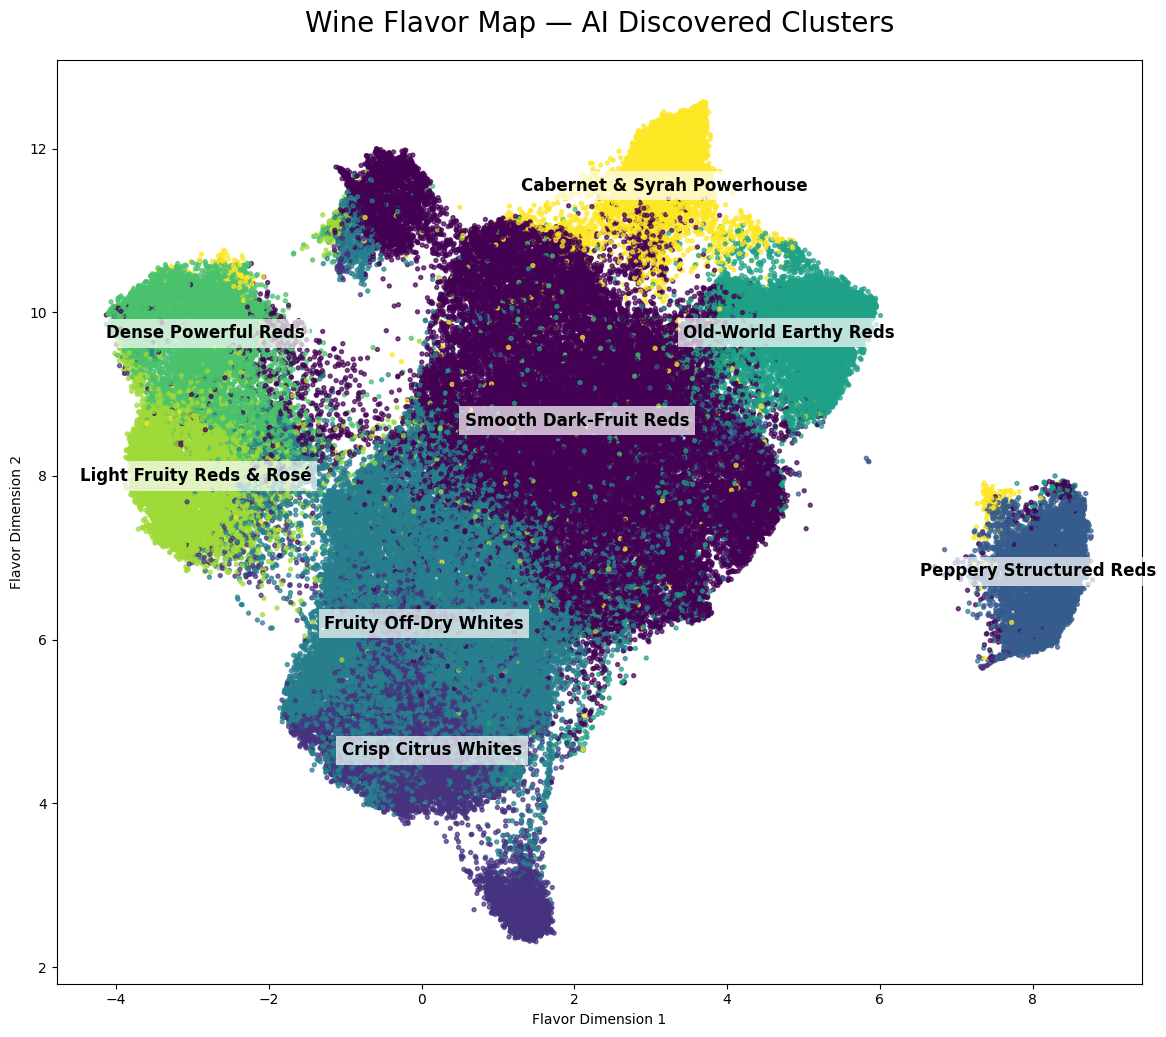

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(14, 12))

# Plot
scatter = plt.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    c=df_clean["cluster"],
    s=8,
    alpha=0.7
)

plt.title("Wine Flavor Map — AI Discovered Clusters", fontsize=20, pad=20)
plt.xlabel("Flavor Dimension 1")
plt.ylabel("Flavor Dimension 2")

# Cluster names you can adjust
cluster_names = {
    0: "Smooth Dark-Fruit Reds",
    1: "Crisp Citrus Whites",
    2: "Peppery Structured Reds",
    3: "Fruity Off-Dry Whites",
    4: "Old-World Earthy Reds",
    5: "Dense Powerful Reds",
    6: "Light Fruity Reds & Rosé",
    7: "Cabernet & Syrah Powerhouse"
}

# Annotate each cluster at its median position
for clust in range(8):
    idx = np.where(df_clean["cluster"] == clust)[0]
    x_med = np.median(X_umap[idx, 0])
    y_med = np.median(X_umap[idx, 1])
    plt.text(
        x_med, y_med, cluster_names[clust],
        fontsize=12, weight="bold",
        ha="center", va="center",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
    )


plt.savefig("wine_flavor_map.png", dpi=300, bbox_inches="tight")
plt.show()

In [28]:
X_reduced.shape

(120974, 50)

In [29]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

X_tensor = torch.tensor(X_reduced, dtype=torch.float32)

dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=256, shuffle=True)

In [30]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim=50, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

model = AutoEncoder(input_dim=50, latent_dim=16)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [33]:
for epoch in range(100):  # you can increase later
    total_loss = 0.0
    model.train()
    for (batch,) in loader:
        optimizer.zero_grad()
        recon = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.size(0)

    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}, loss = {avg_loss:.4f}")

Epoch 1, loss = 0.0008
Epoch 2, loss = 0.0008
Epoch 3, loss = 0.0008
Epoch 4, loss = 0.0008
Epoch 5, loss = 0.0008
Epoch 6, loss = 0.0007
Epoch 7, loss = 0.0007
Epoch 8, loss = 0.0007
Epoch 9, loss = 0.0007
Epoch 10, loss = 0.0007
Epoch 11, loss = 0.0007
Epoch 12, loss = 0.0007
Epoch 13, loss = 0.0007
Epoch 14, loss = 0.0007
Epoch 15, loss = 0.0007
Epoch 16, loss = 0.0007
Epoch 17, loss = 0.0007
Epoch 18, loss = 0.0007
Epoch 19, loss = 0.0007
Epoch 20, loss = 0.0007
Epoch 21, loss = 0.0007
Epoch 22, loss = 0.0007
Epoch 23, loss = 0.0007
Epoch 24, loss = 0.0007
Epoch 25, loss = 0.0007
Epoch 26, loss = 0.0007
Epoch 27, loss = 0.0007
Epoch 28, loss = 0.0007
Epoch 29, loss = 0.0007
Epoch 30, loss = 0.0007
Epoch 31, loss = 0.0007
Epoch 32, loss = 0.0007
Epoch 33, loss = 0.0007
Epoch 34, loss = 0.0007
Epoch 35, loss = 0.0007
Epoch 36, loss = 0.0007
Epoch 37, loss = 0.0007
Epoch 38, loss = 0.0007
Epoch 39, loss = 0.0007
Epoch 40, loss = 0.0007
Epoch 41, loss = 0.0007
Epoch 42, loss = 0.0007
E

In [34]:
model.eval()
with torch.no_grad():
    Z = model.encoder(X_tensor).numpy()

Z.shape

(120974, 16)